---
---
---
---

# Import Necessary Library

In [1]:
## Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from skimage.transform import resize, rotate
from skimage import io
from skimage.color import rgb2gray
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tabulate import tabulate
## Set a random seed for reproducibility
np.random.seed(42)

2023-09-29 04:07:10.770032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 04:07:10.996149: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-29 04:07:11.007429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 04:07:14.759271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# User-Defined Functions and Classes

## Class: evaluate_classification_model
> The class is typically used to evaluate classification models by initializing an instance with true labels (y_true) and predicted labels (y_pred).  
 Users can then call various methods to calculate and print different evaluation metrics and generate a confusion matrix heatmap.

In [2]:
class evaluate_classification_model:
    """
    A class for evaluating the performance of a binary or multiclass classification model.

    Attributes:
        TP (int): True Positives counter.
        FP (int): False Positives counter.
        TN (int): True Negatives counter.
        FN (int): False Negatives counter.

    Methods:
        __init__(self, y_true, y_pred, multiclass=False, classes_name=[]):
            Initializes the evaluation counters based on actual and predicted labels.
            Args:
                y_true (list): List of true labels (0 or 1) or class labels for multiclass.
                y_pred (list): List of predicted labels (0 or 1) or class labels for multiclass.
                multiclass (bool): Indicates whether the classification is multiclass. Default is False for binary classification.

        get_precision(self, average_type="macro"):
            Calculates and returns the precision score.
            Args:
                average_type (str): The type of averaging for precision calculation.
                    Should be one of ["macro", "micro"], default value is "macro".

        print_precision(self):
            Prints the precision score.

        get_recall(self, average_type="macro"):
            Calculates and returns the recall score.
            Args:
                average_type (str): The type of averaging for recall calculation.
                    Should be one of ["macro", "micro"], default value is "macro".

        print_recall(self):
            Prints the recall score.

        get_accuracy(self, average_type="macro"):
            Calculates and returns the accuracy score.
            Args:
                average_type (str): The type of averaging for accuracy calculation.
                    Should be one of ["macro", "micro"], default value is "macro".

        print_accuracy(self):
            Prints the accuracy score.

        get_f1_score(self, average_type="macro"):
            Calculates and returns the F1 score.
            Args:
                average_type (str): The type of averaging for F1 score calculation.
                    Should be one of ["macro", "micro"], default value is "macro".

        print_f1_score(self):
            Prints the F1 score.

        conf_matrix(self, class_labels=[]):
            Generates and displays a confusion matrix heatmap using Matplotlib.
            Args:
                class_labels (list, optional): List of class labels for multiclass confusion matrix.

        print_model_report(self):
            Prints a comprehensive report with precision, recall, accuracy, and F1 score.

    Usage:
        # Initialize the evaluator with actual and predicted labels
        evaluator = evaluate_classification_model(y_true, y_pred, multiclass=False)

        # Calculate and print various evaluation metrics
        print("Precision:", evaluator.get_precision())
        print("Recall:", evaluator.get_recall())
        print("Accuracy:", evaluator.get_accuracy())
        print("F1 Score:", evaluator.get_f1_score())

        # Display the confusion matrix
        evaluator.conf_matrix()

    Example for Multiclass Classification:
        # Initialize the evaluator with actual and predicted labels for multiclass classification
        evaluator = evaluate_classification_model(y_true, y_pred, multiclass=True)

        # Calculate and print various evaluation metrics for multiclass classification
        evaluator.print_precision()
        evaluator.print_recall()
        evaluator.print_accuracy()
        evaluator.print_f1_score()

        # Display the confusion matrix for multiclass classification
        evaluator.conf_matrix(class_labels=["Class 0", "Class 1", "Class 2"])
    """
    
    __paramert_table = {"headers": "keys", "tablefmt": "grid", "showindex": False, "stralign": "center", "numalign": "center"}

    def __init__(self, y_true, y_pred, multiclass=False, classes_name=[]):
        """
        Initializes the evaluation counters based on actual and predicted labels.

        Args:
            y_true (list): List of true labels (0 or 1) or class labels for multiclass.
            y_pred (list): List of predicted labels (0 or 1) or class labels for multiclass.
            multiclass (bool): Indicates whether the classification is multiclass. Default is False for binary classification.
        """
        self.multiclass = multiclass
        
        if classes_name == []:
            self.classes_of_data = [f"classe_{class_name}" for class_name in np.unique(y_true)]
        else:
            self.classes_of_data = classes_name.copy()
        
        if not multiclass:
            # Binary classification
            # Initialize counters for TP, FP, TN, and FN
            self.TP = 0
            self.FP = 0
            self.TN = 0
            self.FN = 0
            
            # Calculate TP, FP, TN, and FN
            for true, pred in zip(y_true, y_pred):
                if true == 1 and pred == 1:
                    self.TP += 1
                elif true == 0 and pred == 1:
                    self.FP += 1
                elif true == 1 and pred == 0:
                    self.FN += 1
                elif true == 0 and pred == 0:
                    self.TN += 1
        else:
            # Multiclass classification
            classes_num = len(self.classes_of_data)
            self.classes_rates = []
            self.cof = np.zeros(shape=(classes_num, classes_num))
            
            for pred, act in zip(y_pred, y_true):
                self.cof[act][pred] += 1
            
            for class_num, class_name in enumerate(self.classes_of_data):
                
                TP_tem = self.cof[class_num][class_num]
                FP_tem = self.cof[:, class_num].sum() - TP_tem
                FN_tem = self.cof[class_num, :].sum() - TP_tem
                TN_tem = self.cof.sum() - (TP_tem + FP_tem + FN_tem)
                self.classes_rates.append({"TP": TP_tem, "FP": FP_tem, "TN": TN_tem, "FN": FN_tem})
    
    def __Calculate_precision(self, TP, FP):
        return (TP / (TP + FP))
    
    def __Calculate_recall(self, TP, FN):
        return (TP / (TP + FN))
    
    def __Calculate_accuracy(self, TP, FP, TN, FN):
        return ((TP + TN) / (TP + FP + TN + FN))
    
    def __Calculate_f1_score(self, precision_score, recall_score):
        return ((2 * precision_score * recall_score) / (precision_score + recall_score))
          
    def __precision_table(self):
        if not self.multiclass:
            table_data = [{"metric": "precision", "value": self.get_precision()}]
        else:
            macro_precision = self.get_precision("macro")
            micro_precision = self.get_precision("micro")
            precision_dict = {class_name: pre_val for class_name, pre_val in self.classes_precision.items()}
            table_data = [{"metric": "precision"}]
            table_data[0].update(precision_dict)            
            precision_data = {"Macro average": macro_precision, "Micro average": micro_precision}
            table_data[0].update(precision_data)  
        return table_data
    
    def __recall_table(self):
        if not self.multiclass:
            table_data = [{"metric": "recall", "value": self.get_recall()}]
        else:
            macro_recall = self.get_recall("macro")
            macro_recall = self.get_recall("micro")       
            recall_dict = {class_name: recall_val for class_name, recall_val in self.classes_recall.items()}
            table_data = [{"metric": "recall"}]
            table_data[0].update(recall_dict)            
            recall_data = {"Macro average": macro_recall, "Micro average": macro_recall}
            table_data[0].update(recall_data)            
        return table_data
    
    def __accuracy_table(self):
        if not self.multiclass:
            table_data = [{"metric": "Accuracy", "value": self.get_accuracy()}]
        else:
            macro_accuracy = self.get_accuracy("macro")
            micro_accuracy = self.get_accuracy("micro")
            accuracy_dict = {class_name: accuracy_val for class_name, accuracy_val in self.classes_accuracy.items()}
            table_data = [{"metric": "accuracy"}]
            table_data[0].update(accuracy_dict)            
            accuracy_data = {"Macro average": macro_accuracy, "Micro average": micro_accuracy}
            table_data[0].update(accuracy_data)            
        return table_data
    
    def __f1_score_table(self):
        if not self.multiclass:
            table_data = [{"metric": "F1 Score", "value": self.get_f1_score()}]
        else:
            macro_f1_score = self.get_f1_score("macro")
            micro_f1_score = self.get_f1_score("micro")
            f1_score_dict = {class_name: f1_score_val for class_name, f1_score_val in self.classes_f1.items()}
            table_data = [{"metric": "f1_score"}]
            table_data[0].update(f1_score_dict)            
            f1_score_data = {"Macro average": macro_f1_score, "Micro average": micro_f1_score}
            table_data[0].update(f1_score_data)            
        return table_data
      
    def get_precision(self, average_type="macro"):
        """
        Calculate precision.

        Args:
            average_type (str): The type of averaging for precision calculation.
                Should be one of ["macro", "micro"], default value is "macro".
        """
        if not self.multiclass:
            return self.__Calculate_precision(self.TP, self.FP)
        else:
            self.classes_precision = {}
            if average_type == "macro":
                precision_sum = 0
                for rate, class_name in zip(self.classes_rates, self.classes_of_data):
                    self.classes_precision[class_name] = self.__Calculate_precision(rate["TP"], rate["FP"])
                    precision_sum += self.__Calculate_precision(rate["TP"], rate["FP"])
                return precision_sum / len(self.classes_rates)
            elif average_type == "micro":
                TP_sum = 0
                FP_sum = 0
                for rate, class_name in zip(self.classes_rates, self.classes_of_data):
                    self.classes_precision[class_name] = self.__Calculate_precision(rate["TP"], rate["FP"])
                    TP_sum += rate["TP"]
                    FP_sum += rate["FP"]
                return self.__Calculate_precision(TP_sum, FP_sum)
    
    def get_recall(self, average_type="macro"):
        """
        Calculate recall.

        Args:
            average_type (str): The type of averaging for recall calculation.
                Should be one of ["macro", "micro"], default value is "macro".
        """
        if not self.multiclass:
            return self.__Calculate_recall(self.TP, self.FN)
        else:
            self.classes_recall = {}
            if average_type == "macro":
                recall_sum = 0
                for rate, class_name in zip(self.classes_rates, self.classes_of_data):
                    self.classes_recall[class_name] = self.__Calculate_precision(rate["TP"], rate["FN"])
                    recall_sum += self.__Calculate_recall(rate["TP"], rate["FN"])
                return recall_sum / len(self.classes_rates)
            elif average_type == "micro":
                TP_sum = 0
                FN_sum = 0
                for class_num, (rate, class_name) in enumerate(zip(self.classes_rates, self.classes_of_data)):
                    self.classes_recall[class_name] = self.__Calculate_precision(rate["TP"], rate["FN"])
                    TP_sum += rate["TP"]
                    FN_sum += rate["FN"]
                return self.__Calculate_recall(TP_sum, FN_sum)
    
    def get_accuracy(self, average_type="macro"):
        """
        Calculate accuracy.

        Args:
            average_type (str): The type of averaging for accuracy calculation.
                Should be one of ["macro", "micro"], default value is "macro".
        """
        if not self.multiclass:
            return self.__Calculate_accuracy(self.TP, self.FP, self.TN, self.FN)
        else:
            self.classes_accuracy = {}
            if average_type == "macro":
                accuracy_sum = 0
                for rate, class_name in zip(self.classes_rates, self.classes_of_data):
                    self.classes_accuracy[class_name] = self.__Calculate_accuracy(rate["TP"], rate["FP"], rate["TN"], rate["FN"])
                    accuracy_sum += self.classes_accuracy[class_name]
                    
                return accuracy_sum / len(self.classes_rates)
            elif average_type == "micro":
                TP_sum = 0
                FP_sum = 0
                TN_sum = 0
                FN_sum = 0
                for rate, class_name in zip(self.classes_rates, self.classes_of_data):
                    self.classes_accuracy[class_name] = self.__Calculate_accuracy(rate["TP"], rate["FP"], rate["TN"], rate["FN"])
                    TP_sum += rate["TP"]
                    FP_sum += rate["FP"]
                    TN_sum += rate["TN"]
                    FN_sum += rate["FN"]
                    
                return self.__Calculate_accuracy(TP_sum, FP_sum, TN_sum, FN_sum)
    
    def get_f1_score(self, average_type="macro"):
        """
        Calculate F1 score.

        Args:
            average_type (str): The type of averaging for F1 score calculation.
                Should be one of ["macro", "micro"], default value is "macro".
        """
        if not self.multiclass:
            pre = self.get_precision()
            rec = self.get_recall()
            return self.__Calculate_f1_score(pre, rec)
        else:
            self.classes_f1 = {}
            if average_type == "macro":
                pre = self.get_precision("macro")
                rec = self.get_recall("macro")
            elif average_type == "micro":
                pre = self.get_precision("macro")
                rec = self.get_recall("micro")
            
            for precision, recall, class_name in zip(self.classes_precision.values(), self.classes_recall.values(), self.classes_of_data):
                self.classes_f1[class_name] = self.__Calculate_f1_score(precision, recall)
                
            return self.__Calculate_f1_score(pre, rec)
    
    def print_precision(self):
        table = self.__precision_table()
        print(tabulate(table, **self.__paramert_table), "\n")
    
    def print_recall(self):
        table = self.__recall_table()
        print(tabulate(table, **self.__paramert_table), "\n")
    
    def print_accuracy(self):
        table = self.__accuracy_table()
        print(tabulate(table, **self.__paramert_table), "\n")
    
    def print_f1_score(self):
        table = self.__f1_score_table()
        print(tabulate(table, **self.__paramert_table), "\n")
            
    def print_model_report(self):
        precision_table = self.__precision_table()
        recall_table = self.__recall_table()
        accuracy_table = self.__accuracy_table()
        f1_score_table = self.__f1_score_table()
        concatenated_table = precision_table + recall_table + accuracy_table + f1_score_table
        
        print(tabulate(concatenated_table, **self.__paramert_table), "\n")

    def conf_matrix(self, class_labels=[]):
        """
        Generates and displays a confusion matrix heatmap using Matplotlib.

        Args:
            class_labels (list, optional): List of class labels for multiclass confusion matrix.
        """
        if not self.multiclass:
            confusion_matrix = np.array([[self.TP, self.FP], [self.FN, self.TN]])
        else:
            confusion_matrix = self.cof

        if not class_labels:
            class_labels = self.classes_of_data.copy()

        # Create a figure and axis for the heatmap
        fig, ax = plt.subplots()

        # Plot the heatmap of the confusion matrix using a blue colormap
        cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)

        # Set labels for the x and y axes based on class labels
        plt.xticks(np.arange(len(class_labels)), class_labels)
        plt.yticks(np.arange(len(class_labels)), class_labels)

        # Display the values in the heatmap at their respective positions
        for i in range(len(class_labels)):
            for j in range(len(class_labels)):
                plt.text(j, i, str(confusion_matrix[i, j]), va='center', ha='center', color='black', fontsize=14)

        # Set labels for the x and y axes
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # Add a title to the confusion matrix plot
        ax.set_title("Confusion Matrix", loc='center', fontsize=18)

        # Display the plot
        plt.show()


## Function: multiclass_ROC
The multiclass_ROC function takes a trained multiclass classification model, input data, and true labels as input and produces ROC curves  
for each class in the multiclass problem. ROC curves are useful for visualizing the model's ability to distinguish between different classes,   
especially in scenarios with multiple classes.

In [3]:
def multiclass_ROC(model, x, y):
    """
    Generate a Receiver Operating Characteristic (ROC) curve for a multiclass classification model.

    Args:
        model: The trained multiclass classification model.
        x: Input data for which ROC curves will be generated.
        y: True labels corresponding to the input data.

    This function calculates and plots the ROC curves for each class in a multiclass classification problem.
    It is particularly useful for visualizing the model's performance in distinguishing between different classes.

    Returns:
        None
    """
    # Initialize ROC curve variables
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Determine the number of unique classes
    n_classes = len(np.unique(y))

    # Binarize the true labels for ROC curve calculation
    y_true_bin = label_binarize(y, classes=np.arange(n_classes))

    # Obtain predicted class probabilities
    y_scores = model.predict_proba(x)

    # Calculate ROC curve for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'aqua']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

    # Plot the diagonal (random guessing) line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Set plot limits and labels
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
    plt.legend(loc="lower right")

    # Display the ROC curve plot
    plt.show()


## Function: create_random_index
The create_random_index function takes an integer num_indx as input and produces a list of unique random indices within the range from 0 to num_indx - 1. It ensures that each index in the list is unique, preventing duplicates. This function is commonly used for tasks like random data sampling and shuffling of data indices.

In [4]:
def create_random_index(num_indx):
    """
    Generate a list of unique random indices within a specified range.

    Args:
        num_indx (int): The total number of unique indices to generate.

    This function generates a list of unique random indices within the range from 0 to `num_indx - 1`.
    The function ensures that each index in the list is unique, preventing duplicates.
    It's commonly used for random sampling and shuffling of data indices.

    Returns:
        list: A list of unique random indices.
    """
    random_indx = []
    
    # Initialize a seed value for random number generation
    np.random.seed(42)
    
    for i in range(num_indx):
        rand_num = np.random.randint(num_indx)
        
        # Check if the random index is not already in the list
        if rand_num not in random_indx:
            random_indx.append(rand_num)
        else:
            # If a duplicate is encountered, find a new unique random index
            while rand_num in random_indx:
                rand_num = np.random.randint(num_indx)
            random_indx.append(rand_num)
    
    return random_indx


# Prepare Datasets

## Datasets Location

In this section, we maintain a dictionary called ```dataset_Location``` to store data locations for convenient access and image loading.

>* To make this notebook work properly, you need to change the paths in the dataset_Location dictionary  
 to match the actual locations where your datasets are stored.

In [5]:
# Dictionary to store the file paths for different datasets
dataset_Location = {
    '4_dataset_loc': "./dataset/English/Img/GoodImg/Bmp/Sample005",
    'A_dataset_loc': "./dataset/English/Img/GoodImg/Bmp/Sample011",
    'u_dataset_loc': "./dataset/English/Img/GoodImg/Bmp/Sample057",
    'H_dataset_loc': "./dataset/English/Img/GoodImg/Bmp/Sample018"
}

## Find  Images location

In this section, we combine the dataset path with each image name and store the outcomes in a dictionary named ```datasets_images```.

In [6]:
# Organize image files into groups based on character/digit labels in a dictionary.
datasets_images = {data_name[:-4]: os.listdir(loc) for data_name, loc in dataset_Location.items()}

## Load and store Images.

In this section, we extract images from their respective file paths as NumPy arrays and  converte them to grayscale.

* We use the scikit-image library to read the images, and concurrently, we display the number of records associated with each dataset and store it in dictinary named ```RGB_datasets_numpy```

number of records in DataSet '4': 47
number of records in DataSet 'A': 558
number of records in DataSet 'u': 41
number of records in DataSet 'H': 193


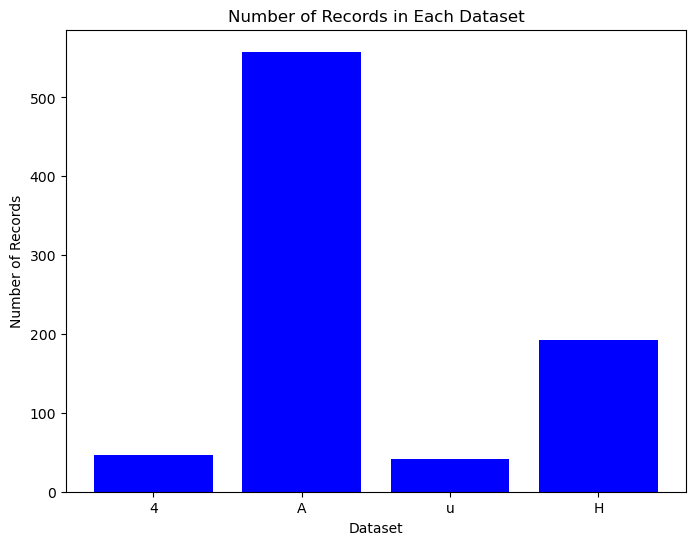

In [7]:
imgs_size=tuple()
largest_dataset=0

# Creating a dictionary 'datasets_numpy' to store images as NumPy arrays 
RGB_datasets_numpy = {}
# Iterate through 'datasets_images' to load images and organize them by character/digit labels
for dataset, image_names in datasets_images.items():
    
    data_name = dataset.split('_')[0]
    # Load images using scikit-image and store them in a list
    RGP_np_image_list = [io.imread(os.path.join(dataset_Location["_".join([dataset, 'loc'])], count)) for count in image_names]
    RGB_datasets_numpy[data_name] = RGP_np_image_list.copy()
    number_of_imgs=len(RGP_np_image_list)
    print(f"number of records in DataSet '{data_name}': {number_of_imgs}")
    if largest_dataset<number_of_imgs:
        largest_dataset=number_of_imgs
    # Clear the Temps lists
    RGP_np_image_list.clear()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(list(RGB_datasets_numpy.keys()),[len(data_len) for data_len in list(RGB_datasets_numpy.values())], color='blue')
plt.xlabel('Dataset')
plt.ylabel('Number of Records')
plt.title('Number of Records in Each Dataset')
plt.show()

* As we can see from the previous results, our data isn't balanced. To address this, we'll employ data augmentation methods to balance it. Afterward, we'll convert each image to grayscale and store them in a dictionary called  `Gray_datasets_numpy`.

New number of Data record for '4' Dataset=564
New number of Data record for 'A' Dataset=558
New number of Data record for 'u' Dataset=574
New number of Data record for 'H' Dataset=579


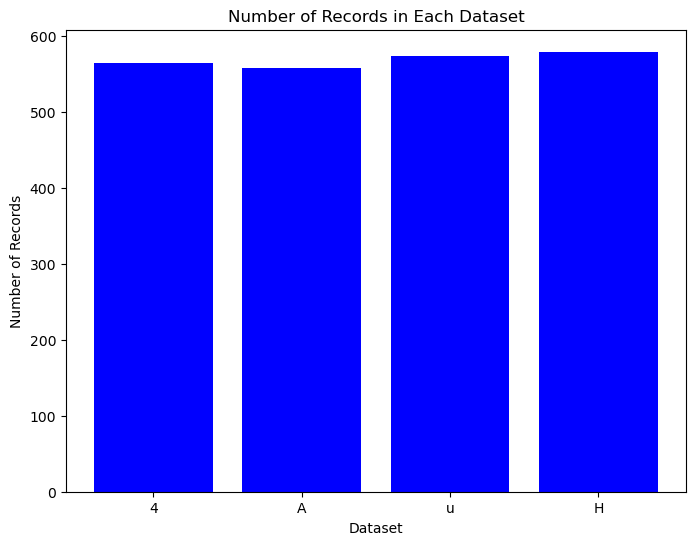

In [8]:
# Create an empty dictionary to store grayscale images
Gray_datasets_numpy = {}

# Create an empty list to hold modified data
modefid_data = []

# Create an empty list to store image lists
img_list = []

# Initialize an ImageDataGenerator with data augmentation options
datagen = ImageDataGenerator(
    rotation_range=0.05,
    fill_mode='constant',
)

# Iterate through datasets in RGB format
for data_name, RGP_np_image_list in RGB_datasets_numpy.items():
    number_of_imgs = len(RGP_np_image_list)
    
    # Clear the modified data list and copy the original image list
    modefid_data.clear()
    modefid_data = RGP_np_image_list.copy()
    
    # Check if the dataset has fewer images than the largest dataset
    if number_of_imgs < largest_dataset:
        # Calculate the data balancing ratio
        data_balanced_ratio = int((largest_dataset / number_of_imgs) - ((largest_dataset / number_of_imgs) % 1))
        
        # Augment data to balance it
        for count in range(data_balanced_ratio):
            for img in RGP_np_image_list:
                augmented_img_list = datagen.random_transform(img)
                modefid_data.append(augmented_img_list)
    
    # Convert the images from RGB to grayscale
    Grey_np_image_list = [rgb2gray(rgp_img) for rgp_img in modefid_data]
    
    # Store the grayscale images in the Gray_datasets_numpy dictionary
    Gray_datasets_numpy[data_name] = Grey_np_image_list
    
    # Print the new number of data records for the dataset
    print(f"New number of Data record for '{data_name}' Dataset", len(Grey_np_image_list), sep='=')

# Create a bar plot to visualize the number of records in each dataset
plt.figure(figsize=(8, 6))
plt.bar(list(Gray_datasets_numpy.keys()), [len(data_len) for data_len in list(Gray_datasets_numpy.values())], color='blue')
plt.xlabel('Dataset')
plt.ylabel('Number of Records')
plt.title('Number of Records in Each Dataset')
plt.show()


> (Optional) In this cell, we calculate the maximum, minimum, and average sizes of all the images. We can use these statistics for resizing the images if needed.

In [9]:
## Initialize variables to track the minimum and maximum image sizes
min_size = (1000, 1000)
max_size = (0, 0)
average_width=0
average_hight=0
img_counts=0
## Iterate through each dataset to find the minimum and maximum image sizes
for dataset_name, numpy_list in Gray_datasets_numpy.items():
    for img in numpy_list:
        ## Check if the current image size is smaller than the current minimum size
        if img.shape < min_size:
            min_size = img.shape
        ## Check if the current image size is larger than the current maximum size
        if img.shape > max_size:
            max_size = img.shape
        average_width+=img.shape[0]
        average_hight+=img.shape[1]
        img_counts+=1
## Calculate the average image size
average_size = (int(average_width/img_counts), int(average_hight/img_counts))
## Print the maximum, minimum, and average image sizes with proper formatting
print(f"Maximum Image Size: {max_size}".title(), f"Minimum Image Size: {min_size}".title(), f"Average Image Size: {average_size}".title(), sep="\n")


Maximum Image Size: (426, 534)
Minimum Image Size: (13, 15)
Average Image Size: (80, 60)


* After making the data more balanced, you want to resize all the images to the same size using the `resize` function from the skimage library.
This will ensure that all images have the same dimensions.

* When we resize the images, we can choose to use their largest size, smallest size, average size, or a size we specify. After looking at the previous output, we noticed that the sizes can be quite different, some too big and some too small. So, we've decided to make all the images the same size, specifically 128 pixels by 128 pixels.

In [10]:
## Define the target image size 
#imgs_size = min_size
#imgs_size = max_size
#imgs_size = average_size
imgs_size = (128, 128)
## Iterate through each dataset and resize its grayscale images to the target size
for dataset_name, numpy_list in Gray_datasets_numpy.items():
    # Resize each image in the dataset to the specified target size
    Gray_datasets_numpy[dataset_name] = [resize(img, imgs_size) for img in numpy_list]
## Print the chosen image size
print(f"Image Sizes = ({imgs_size[0]} x {imgs_size[1]})")

Image Sizes = (128 x 128)


* Now, let's take a look at our images after performing the following steps:
    * Data augmentation
    * Resizing the image size
    * Converting the images to grayscale

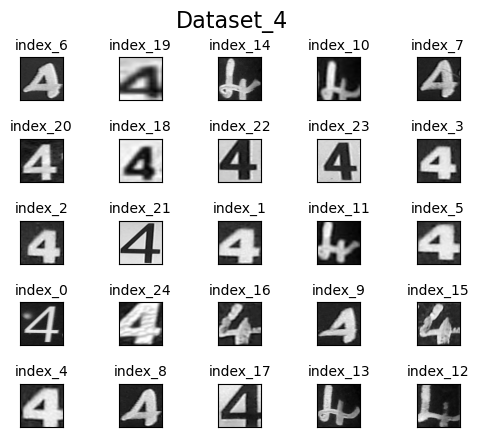

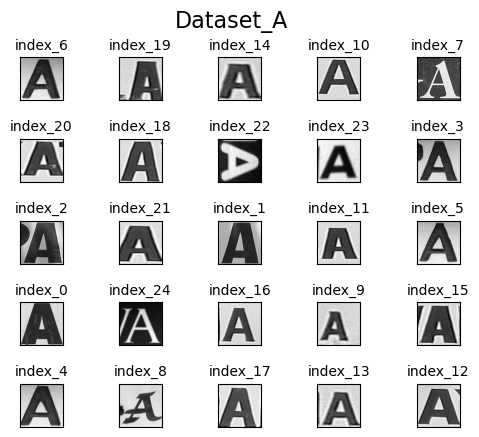

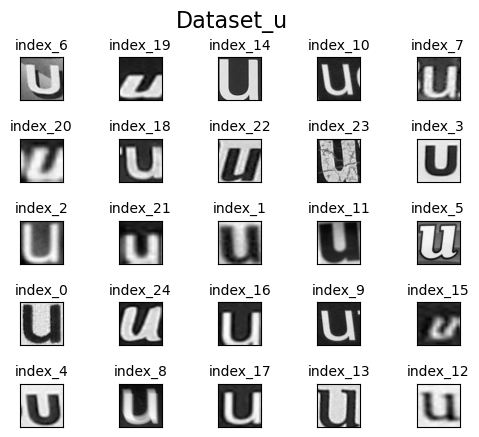

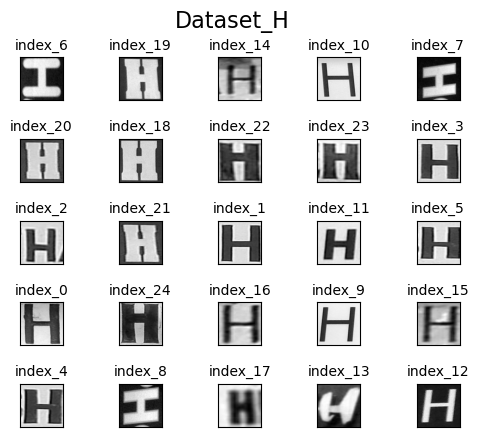

In [11]:
sample=5
index_data_list={data_name: create_random_index(sample*sample) for data_name in Gray_datasets_numpy.keys()}
figs={data_name:plt.figure() for data_name in Gray_datasets_numpy.keys()}
for data_name,img_list in Gray_datasets_numpy.items():
    index=index_data_list[data_name]
    figs[data_name].suptitle(f'Dataset_{data_name}', fontsize=16)
    for row in range(sample):
        for col in range(sample):
            figs[data_name].subplots_adjust(hspace=0.9,wspace=0.0)
            ax = figs[data_name].add_subplot(sample,sample,sample*row+col+1)
            ax.set_title(f"index_{index[5*row+col]}",fontsize=10)  
            ax.imshow(img_list[index[5*row+col]],cmap='gray')
            
            ax.set_xticks([])
            ax.set_yticks([])
            
plt.show()
            

## Dataset as DataFrame

To better manage and organize our data, we create a DataFrame. In this DataFrame, each row represents one image, and each column represents one pixel in our data. We also include a column called "label" to indicate which character or digit each image corresponds to.

In [12]:
# Create an empty DataFrame with columns representing pixel values
df = pd.DataFrame(columns=[f'pix_{i}' for i in range(imgs_size[0] * imgs_size[1])])
df['label'] = None
df.head()

Empty DataFrame
Columns: [pix_0, pix_1, pix_2, pix_3, pix_4, pix_5, pix_6, pix_7, pix_8, pix_9, pix_10, pix_11, pix_12, pix_13, pix_14, pix_15, pix_16, pix_17, pix_18, pix_19, pix_20, pix_21, pix_22, pix_23, pix_24, pix_25, pix_26, pix_27, pix_28, pix_29, pix_30, pix_31, pix_32, pix_33, pix_34, pix_35, pix_36, pix_37, pix_38, pix_39, pix_40, pix_41, pix_42, pix_43, pix_44, pix_45, pix_46, pix_47, pix_48, pix_49, pix_50, pix_51, pix_52, pix_53, pix_54, pix_55, pix_56, pix_57, pix_58, pix_59, pix_60, pix_61, pix_62, pix_63, pix_64, pix_65, pix_66, pix_67, pix_68, pix_69, pix_70, pix_71, pix_72, pix_73, pix_74, pix_75, pix_76, pix_77, pix_78, pix_79, pix_80, pix_81, pix_82, pix_83, pix_84, pix_85, pix_86, pix_87, pix_88, pix_89, pix_90, pix_91, pix_92, pix_93, pix_94, pix_95, pix_96, pix_97, pix_98, pix_99, ...]
Index: []

[0 rows x 16385 columns]

* After creating an empty DataFrame, we will populate it by storing the images.

In [13]:
# Iterate through the datasets in datasets_numpy
for data_name, img_list in Gray_datasets_numpy.items():
    # Iterate through the list of images for each data_name
    for img in img_list:
        # Flatten the pixel values from a 2D array to a 1D array
        img=img.reshape(1, -1)#/255
        # Create a temporary DataFrame containing the flattened pixel values
        df_tem = pd.DataFrame(img,columns=df.columns[:-1])
        # Add a 'label' column with the value of 'data_name'
        df_tem['label'] = data_name
        # Concatenate the temporary DataFrame with the main DataFrame 'df'
        df = pd.concat([df, df_tem],axis=0)
# Reset the index and drop the old index column to create the final DataFrame
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

pix_0     pix_1     pix_2     pix_3     pix_4     pix_5     pix_6  \
0  0.114984  0.053507  0.007969  0.069446  0.130922  0.192399  0.253875   
1  0.039516  0.072322  0.184161  0.192837  0.194822  0.196457  0.197231   
2  0.663311  0.663311  0.663311  0.662533  0.660978  0.658240  0.654319   
3  0.157079  0.159582  0.162084  0.164586  0.167088  0.164943  0.162441   
4  0.132373  0.134491  0.136610  0.136225  0.134106  0.131987  0.129869   

      pix_7     pix_8     pix_9  ...  pix_16375  pix_16376  pix_16377  \
0  0.292173  0.294048  0.295922  ...   0.287185   0.278810   0.240032   
1  0.197231  0.197231  0.197231  ...   0.189571   0.189741   0.189741   
2  0.652155  0.651749  0.651749  ...   0.675110   0.675179   0.677208   
3  0.159939  0.157437  0.154935  ...   0.566403   0.509198   0.451993   
4  0.127750  0.125631  0.125532  ...   0.170818   0.173556   0.176295   

   pix_16378  pix_16379  pix_16380  pix_16381  pix_16382  pix_16383  label  
0   0.181908   0.123784   0.065659   0.007535   0.050590   0.108714      H  
1   0.187663   0.183274   0.183383   0.178277   0.070011   0.038254      u  
2   0.681199   0.675991   0.661583   0.641662   0.616225   0.616225      A  
3   0.394787   0.345754   0.402960   0.460165   0.517370   0.574576      4  
4   0.179033   0.181771   0.184509   0.185007   0.182269   0.179531      A  

[5 rows x 16385 columns]

> The following cell will display random images from the DataFrame to verify if the DataFrame was created successfully.

In [14]:
sample=10
index_data_list= create_random_index(sample*sample)
fig=plt.figure(figsize=(imgs_size))
index=index_data_list
fig.suptitle("DataSet", fontsize=imgs_size[0]*2)
for row in range(sample):
    for col in range(sample):
        ax = fig.add_subplot(sample,sample,sample*row+col+1)
        ax.set_title(f"index_{index[sample*row+col]},lable_{df.iloc[index[sample*row+col],-1:][0]}",fontsize=imgs_size[0]/2)  
        ax.imshow(np.array(df.iloc[index[sample*row+col],:-1],dtype=np.float32).reshape(imgs_size),cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()
            

# Conversion of Data Labels

> To prepare this DataFrame for our training process, we will convert the ```label``` column from a string data type to a numerical data type using label encoding.

In [15]:
# Initialize a LabelEncoder object for converting categorical labels to numerical values
label_encoder = LabelEncoder()
# Use the LabelEncoder to transform the 'label' column and create a new 'encoding_label' column
df['encoding_label'] = label_encoder.fit_transform(df['label'])
# Print a message indicating the label conversion

encodig_dic={k:v for v,k in zip(df['label'].unique(),df['encoding_label'].unique())}

table_data=[{"lable":val,"encoded lable":key} for key,val in encodig_dic.items()]
print(tabulate(table_data,headers='keys',numalign='center',stralign='center'))

 lable    encoded lable
-------  ---------------
   H            2
   u            3
   A            1
   4            0


# Binary Classification

## Train Binary Classification Model 

> for this model, we consider 'Class 4' as ```positive class``` and 'Class A' as ```negative Class```.


* We will split our data into training, validation, and test sets with approximate proportions of 72%, 18%, and 10%, respectively.

In [66]:
# Combine samples labeled as '4' and 'A' for binary classification
train_binary_classification = pd.concat([df[df['label'] == '4'], df[df['label'] == 'A']]).reset_index(drop=True)

# Split the data into training and testing sets
X, x_test, Y, y_test = train_test_split(train_binary_classification.iloc[:, :-2],
                                                    train_binary_classification.iloc[:, -1],
                                                    test_size=0.1, train_size=0.9, shuffle=True,stratify=train_binary_classification.iloc[:, -1])
x_train, x_valdiation, y_train, y_validation = train_test_split(X,Y,test_size=0.2, train_size=0.8, shuffle=True,stratify=Y)

# Reset the index for training and testing dataframes
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
x_valdiation=x_valdiation.reset_index(drop=True)

y_train_4 = y_train.copy()
y_test_4 = y_test.copy()
y_validation_4 = y_validation.copy()


table_data=[{"Data_type":"Trian data","Number_of_Records":x_train.shape[0],"Number_of_feature":x_train.shape[1]},
            {"Data_type":"validation data","Number_of_Records":x_valdiation.shape[0],"Number_of_feature":x_valdiation.shape[1]},
            {"Data_type":"test data","Number_of_Records":x_test.shape[0],"Number_of_feature":x_test.shape[1]}]
print(tabulate(table_data,headers='keys',numalign='center',stralign='center'))

   Data_type      Number_of_Records    Number_of_feature
---------------  -------------------  -------------------
  Trian data             807                 16384
validation data          202                 16384
   test data             113                 16384


* To train our model effectively, we have some important hyperparameters that need to be fine-tuned. These hyperparameters include:
    * C
    * max_iter
    * tol

  To optimize these parameters, we follow these steps:
    1. We select a specific parameter to tune, for example, "C".
    2. We keep all other hyperparameters fixed during this tuning process.
    3. Next, we use our train dataset to train the model with different values of "C."
    4. For each value of "C," we calculate the F1 score using the validation data.
    5. We compare the F1 scores obtained for different "C" values and select the one that gives us the highest F1 score.

  This iterative process helps us find the best combination of hyperparameters that maximize our model's performance while avoiding overfitting.

> Initialize the parameter to choose between these options.

In [67]:
C_paramter=[1/i for i in range(100,1000,100)]
max_iter_paramter=[i for i in range(100,1000,200)]
tol_paramter=[1/i for i in range(100,1000,10)]

> fine-tuned the C paramter

In [68]:
best_C=0
best_f1=0
for C_test in C_paramter:
    clf = LogisticRegression(C=C_test,solver='liblinear',tol=0.001)
    clf.fit(x_train, y_train_4)
    y_pred_validation_test=clf.predict(x_valdiation)
    ev = evaluate_classification_model(y_validation_4, y_pred_validation_test,classes_name=["class_4","class_A"])
    f1_source=ev.get_f1_score()
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_C=C_test    

> fine-tuned the max_iter paramter

In [69]:
best_max_iter=0
best_f1=0
for max_iter_test in max_iter_paramter:
    clf = LogisticRegression(max_iter=max_iter_test,solver='liblinear',C=best_C,tol=0.001)
    clf.fit(x_train, y_train_4)
    y_pred_validation_test=clf.predict(x_valdiation)
    ev = evaluate_classification_model(y_validation_4, y_pred_validation_test,classes_name=["class_4","class_A"])
    f1_source=ev.get_f1_score()
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_max_iter=max_iter_test    

> fine-tuned the tol paramter

In [70]:
best_tol=0
best_f1=0
for tol_test in tol_paramter:
    binary_classification_model = LogisticRegression(tol=tol_test,max_iter=best_max_iter,solver='liblinear')
    binary_classification_model.fit(x_train, y_train_4)
    y_pred_validation_test=clf.predict(x_valdiation)
    ev = evaluate_classification_model(y_validation_4, y_pred_validation_test,classes_name=["class_4","class_A"])
    f1_source=ev.get_f1_score()
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_tol=tol_test 

* Once we determine the best values for the parameters, we store them in a dictionary called ```best_parameters``` These values will be passed to the model for training.

In [71]:
best_parametr={"max_iter":best_max_iter,
               "solver":'liblinear',
                "C":best_C,
                "tol":best_tol}
best_parametr

{'max_iter': 100, 'solver': 'liblinear', 'C': 0.01, 'tol': 0.001}

* For classification, we use the "LogisticRegression" model.   
We train this model using our training data, making sure to use the selected hyperparameters during the training process.

In [72]:
# binary_classification_model = LogisticRegression(max_iter=1000,solver='saga',C=0.05,tol=0.001)#0.0005
binary_classification_model = LogisticRegression(**best_parametr,verbose=1)
# Train the Binary Classification Model on the training data
binary_classification_model_his = binary_classification_model.fit(x_train, y_train_4)


[LibLinear]iter  1 act 3.377e+00 pre 2.972e+00 delta 6.156e-01 f 5.594e+00 |g| 2.251e+01 CG   6
iter  2 act 5.192e-01 pre 4.420e-01 delta 6.156e-01 f 2.217e+00 |g| 5.473e+00 CG   7
iter  3 act 8.008e-02 pre 6.980e-02 delta 6.156e-01 f 1.698e+00 |g| 2.307e+00 CG   6
iter  4 act 8.787e-03 pre 8.184e-03 delta 6.156e-01 f 1.618e+00 |g| 8.714e-01 CG   6
iter  5 act 4.110e-04 pre 4.099e-04 delta 6.156e-01 f 1.609e+00 |g| 1.524e-01 CG   6
iter  6 act 1.609e-05 pre 1.607e-05 delta 6.156e-01 f 1.609e+00 |g| 1.223e-02 CG  10


## Evaluate Binary Classification Model 

* To assess the performance of our model, we utilize the validation data and compute the following metrics:
    * Precision
    * Recall
    * Accuracy
    * F1 Score
* Additionally, we create visualizations like the confusion matrix and ROC curve, which serve as useful indicators for our model's performance.

+-----------+----------+
|  metric   |  value   |
+===========+==========+
| precision | 0.95098  |
+-----------+----------+
|  recall   |   0.97   |
+-----------+----------+
| Accuracy  | 0.960396 |
+-----------+----------+
| F1 Score  | 0.960396 |
+-----------+----------+ 



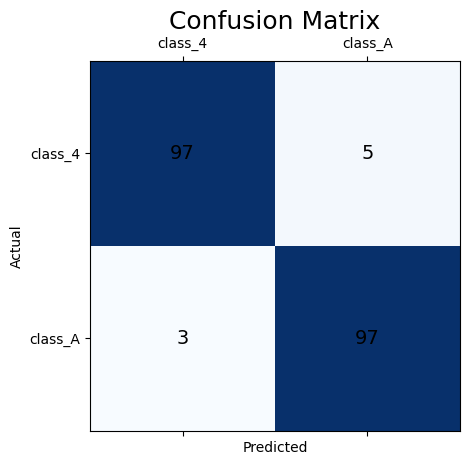

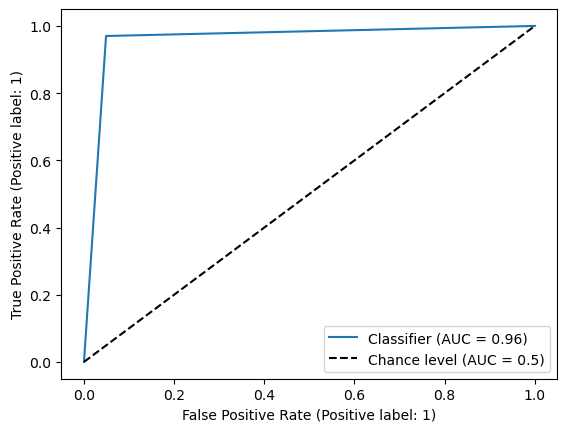

In [73]:
y_pred_validation=binary_classification_model.predict(x_valdiation)
# Initialize the evaluator with actual and predicted labels
validation_evaluator = evaluate_classification_model(y_validation_4, y_pred_validation,classes_name=["class_4","class_A"])
# Calculate and print various evaluation metrics
validation_evaluator.print_model_report()
# Display the confusion matrix
validation_evaluator.conf_matrix()
RocCurveDisplay.from_predictions(y_validation_4,y_pred_validation,plot_chance_level=True)
plt.show()

* From the previous output, we can conclude that our model's performance is satisfactory.  
When examining the ROC curve, we observe that the Area Under the Curve (AUC) is very close to 1,  
indicating that our model's performance is close to ideal.

* Additionally, we assess our model's performance using the training data.

+-----------+----------+
|  metric   |  value   |
+===========+==========+
| precision | 0.954436 |
+-----------+----------+
|  recall   | 0.99005  |
+-----------+----------+
| Accuracy  | 0.971499 |
+-----------+----------+
| F1 Score  | 0.971917 |
+-----------+----------+ 



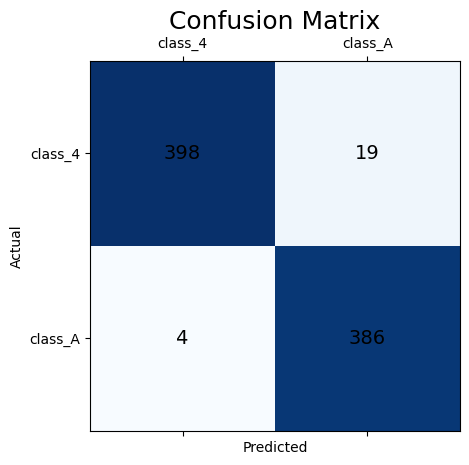

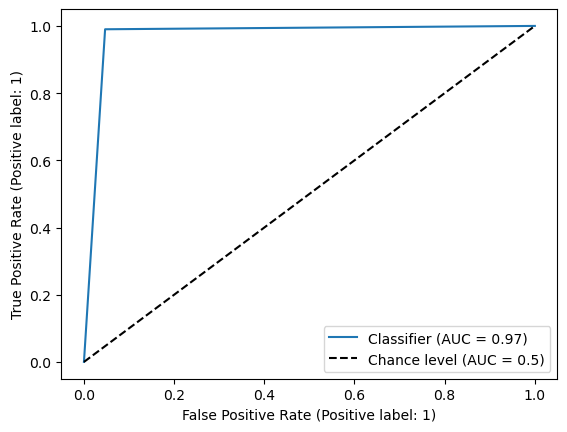

In [74]:
y_pred_train=binary_classification_model.predict(x_train)
# Initialize the evaluator with actual and predicted labels
train_evaluator = evaluate_classification_model(y_train_4, y_pred_train,classes_name=["class_4","class_A"])
# Calculate and print various evaluation metrics
train_evaluator.print_model_report()
# Display the confusion matrix
train_evaluator.conf_matrix()
RocCurveDisplay.from_predictions(y_train_4,y_pred_train,plot_chance_level=True)
plt.show()

* We can also note that the model's performance on the training data is slightly better than on the validation data.  
This could suggest a potential for overfitting, but the difference isn't significant,indicating that the model is not substantially overfitting.

## Test Binary Classification Model 

* Following model training and evaluation, we put the model to the test using the test data to assess its performance.

+-----------+----------+
|  metric   |  value   |
+===========+==========+
| precision | 0.982143 |
+-----------+----------+
|  recall   | 0.982143 |
+-----------+----------+
| Accuracy  | 0.982301 |
+-----------+----------+
| F1 Score  | 0.982143 |
+-----------+----------+ 



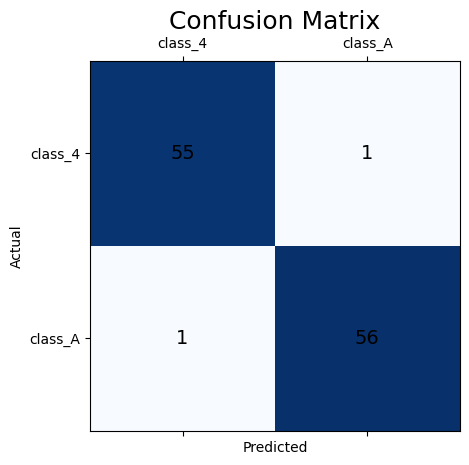

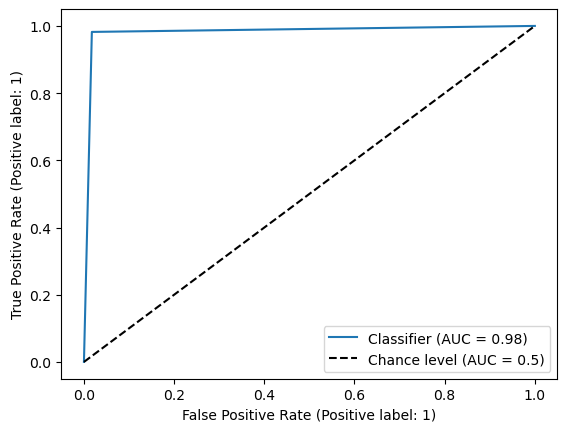

In [75]:
y_pred_test=binary_classification_model.predict(x_test)
# Initialize the evaluator with actual and predicted labels
test_evaluator = evaluate_classification_model(y_test_4, y_pred_test,classes_name=["class_4","class_A"])
# Calculate and print various evaluation metrics
test_evaluator.print_model_report()
# Display the confusion matrix
test_evaluator.conf_matrix()
RocCurveDisplay.from_predictions(y_test_4,y_pred_test,plot_chance_level=True)
plt.show()



* It's evident that the model performs well with the test data, demonstrating its capability to classify the data with reasonable accuracy.

---
---
---
---

# Train Multiclass Classification Model

* After training the binary classification model, we will proceed to train a multiclass classification model using the same LogisticRegression algorithm. We will assess its ability to classify multiple classes.

In [76]:
# Create a new DataFrame for multiclass classification by dropping the 'label' column
train_multiclass_classification = df.drop(['label'], inplace=False, axis=1)
# Display the first few rows of the new DataFrame to inspect the data
train_multiclass_classification.head()

pix_0     pix_1     pix_2     pix_3     pix_4     pix_5     pix_6  \
0  0.114984  0.053507  0.007969  0.069446  0.130922  0.192399  0.253875   
1  0.039516  0.072322  0.184161  0.192837  0.194822  0.196457  0.197231   
2  0.663311  0.663311  0.663311  0.662533  0.660978  0.658240  0.654319   
3  0.157079  0.159582  0.162084  0.164586  0.167088  0.164943  0.162441   
4  0.132373  0.134491  0.136610  0.136225  0.134106  0.131987  0.129869   

      pix_7     pix_8     pix_9  ...  pix_16375  pix_16376  pix_16377  \
0  0.292173  0.294048  0.295922  ...   0.287185   0.278810   0.240032   
1  0.197231  0.197231  0.197231  ...   0.189571   0.189741   0.189741   
2  0.652155  0.651749  0.651749  ...   0.675110   0.675179   0.677208   
3  0.159939  0.157437  0.154935  ...   0.566403   0.509198   0.451993   
4  0.127750  0.125631  0.125532  ...   0.170818   0.173556   0.176295   

   pix_16378  pix_16379  pix_16380  pix_16381  pix_16382  pix_16383  \
0   0.181908   0.123784   0.065659   0.007535   0.050590   0.108714   
1   0.187663   0.183274   0.183383   0.178277   0.070011   0.038254   
2   0.681199   0.675991   0.661583   0.641662   0.616225   0.616225   
3   0.394787   0.345754   0.402960   0.460165   0.517370   0.574576   
4   0.179033   0.181771   0.184509   0.185007   0.182269   0.179531   

   encoding_label  
0               2  
1               3  
2               1  
3               0  
4               1  

[5 rows x 16385 columns]

* We will split our data into training, validation, and test sets with approximate proportions of 72%, 18%, and 10%, respectively.

In [77]:
# Split the data into training and testing sets
X, x_test, Y, y_test = train_test_split(train_multiclass_classification.iloc[:,:-1],
                                        train_multiclass_classification.iloc[:,-1:],
                                        test_size=0.2, train_size=0.8, shuffle=True,stratify=train_multiclass_classification.iloc[:,-1:])

x_train, x_valdiation, y_train, y_validation = train_test_split(X,Y,test_size=0.3, train_size=0.7, shuffle=True,stratify=Y)

# Reset the index for training and testing dataframes
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
x_valdiation=x_valdiation.reset_index(drop=True)
# Flatten the target labels
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_validation=np.ravel(y_validation)


table_data=[{"Data_type":"Trian data","Number_of_Records":x_train.shape[0],"Number_of_feature":x_train.shape[1]},
            {"Data_type":"validation data","Number_of_Records":x_valdiation.shape[0],"Number_of_feature":x_valdiation.shape[1]},
            {"Data_type":"test data","Number_of_Records":x_test.shape[0],"Number_of_feature":x_test.shape[1]}]
print(tabulate(table_data,headers='keys',numalign='center',stralign='center'))

   Data_type      Number_of_Records    Number_of_feature
---------------  -------------------  -------------------
  Trian data            1274                 16384
validation data          546                 16384
   test data             455                 16384


* To train our model effectively, we have some important hyperparameters that need to be fine-tuned. These hyperparameters include:
    * C
    * max_iter
    * tol

  To optimize these parameters, we follow these steps:
    1. We select a specific parameter to tune, for example, "C".
    2. We keep all other hyperparameters fixed during this tuning process.
    3. Next, we use our train dataset to train the model with different values of "C."
    4. For each value of "C," we calculate the F1 score using the validation data.
    5. We compare the F1 scores obtained for different "C" values and select the one that gives us the highest F1 score.

  This iterative process helps us find the best combination of hyperparameters that maximize our model's performance while avoiding overfitting.

> Initialize the parameter to choose between these options.

In [78]:
C_paramter=[1/i for i in range(100,1000,100)]
max_iter_paramter=[i for i in range(100,1000,200)]
tol_paramter=[1/i for i in range(100,1000,10)]

> fine-tuned the C paramter

In [79]:
best_C=0
best_f1=0
for C_test in C_paramter:
    MCM =  LogisticRegression(C=C_test,solver='liblinear',tol=0.001)
    clf = OneVsRestClassifier(MCM,verbose=1,n_jobs=-1)
    clf.fit(x_train, y_train) 
    y_pred_validation_test=clf.predict(x_valdiation)
    ev=evaluate_classification_model(y_validation, y_pred_validation_test,multiclass=True)
    f1_source=ev.get_f1_score(average_type="micro")
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_C=C_test    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4

> fine-tuned the max_iter paramter

In [80]:
best_max_iter=0
best_f1=0
for max_iter_test in max_iter_paramter:
    MCM =  LogisticRegression(max_iter=max_iter_test,solver='liblinear',tol=0.001,C=best_C)
    clf = OneVsRestClassifier(MCM,verbose=1,n_jobs=-1)
    clf.fit(x_train, y_train)  
    y_pred_validation_test=clf.predict(x_valdiation)
    ev=evaluate_classification_model(y_validation, y_pred_validation_test,multiclass=True)
    f1_source=ev.get_f1_score(average_type="micro")
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_max_iter=max_iter_test    


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    8.8s finished


> fine-tuned the tol paramter

In [81]:
best_tol=0
best_f1=0
for tol_test in tol_paramter:
    MCM =  LogisticRegression(tol=tol_test,max_iter=best_max_iter,solver='liblinear')
    clf = OneVsRestClassifier(MCM,verbose=1,n_jobs=-1)
    clf.fit(x_train, y_train) 
    y_pred_validation_test=clf.predict(x_valdiation)
    ev=evaluate_classification_model(y_validation, y_pred_validation_test,multiclass=True)
    f1_source=ev.get_f1_score(average_type="micro")
    if  best_f1 <f1_source:
        best_f1=f1_source
        best_tol=tol_test    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   32.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   28.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   21.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4

* Once we determine the best values for the parameters, we store them in a dictionary called ```best_parameters``` These values will be passed to the model for training.

In [82]:
best_parametr={"max_iter":best_max_iter,
               "solver":'liblinear',
                "C":best_C,
                "tol":best_tol}
best_parametr

{'max_iter': 100, 'solver': 'liblinear', 'C': 0.01, 'tol': 0.005}

* To train a `LogisticRegression` model for multiclass classification, we use a technique called One-vs-Rest (OvR). This approach creates multiple binary classifiers, each focusing on one class as the target while treating all other classes as non-targets. This helps us classify instances into multiple classes.  
We also incorporate the selected hyperparameters during the training process.

In [83]:
multicalss_classification_model = LogisticRegression(**best_parametr)
clf = OneVsRestClassifier(multicalss_classification_model,verbose=1)
clf.fit(x_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=0.01, solver='liblinear',
                                                 tol=0.005),
                    verbose=1)

## Evaluate Multiclass Classification Model 

* To assess the performance of our model, we utilize the validation data and compute the following metrics:
    * Precision
    * Recall
    * Accuracy
    * F1 Score
* Additionally, we create visualizations like the confusion matrix and ROC curve, which serve as useful indicators for our model's performance.

+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  metric   |    4     |    A     |    H     |    u     |  Macro average  |  Micro average  |
+===========+==========+==========+==========+==========+=================+=================+
| precision | 0.884615 | 0.714286 | 0.715517 | 0.856164 |    0.792646     |     0.79304     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  recall   | 0.851852 | 0.820896 | 0.597122 | 0.905797 |     0.79304     |     0.79304     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| accuracy  | 0.935897 | 0.875458 | 0.836996 | 0.937729 |     0.89652     |     0.89652     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| f1_score  | 0.867925 | 0.763889 | 0.65098  | 0.880282 |    0.793281     |    0.792843     |
+-----------+----------+----------+----------+----------+---

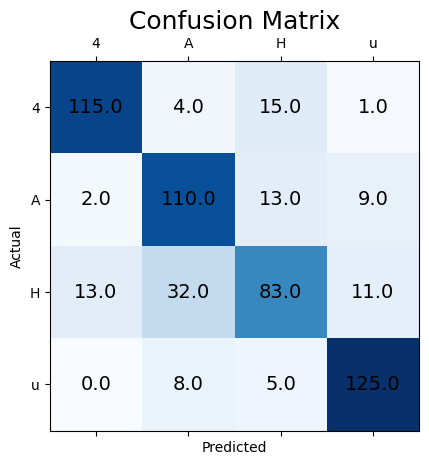

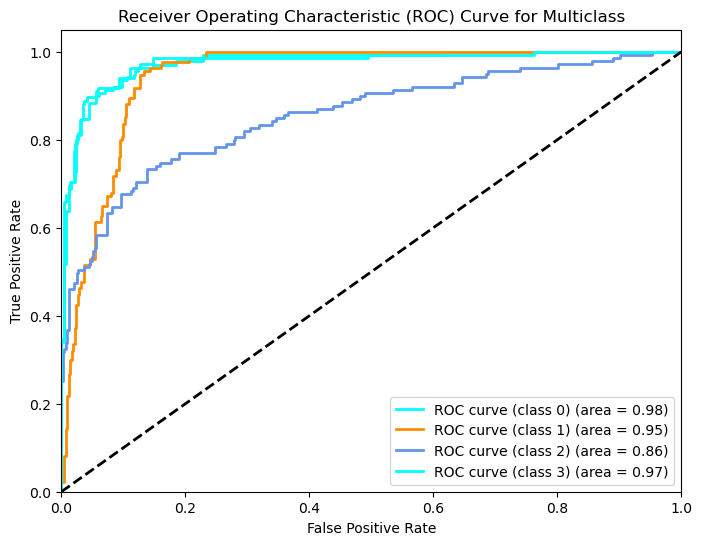

In [84]:
p=clf.predict(x_valdiation)
ev=evaluate_classification_model(y_validation, p,multiclass=True,classes_name=[encodig_dic[class_name] for class_name in np.unique(y_train) ])
ev.print_model_report()
ev.conf_matrix()
multiclass_ROC(clf,x_valdiation,y_validation)

* From the previous output, we can conclude that our model's performance is satisfactory.  
When examining the ROC curve, we observe that the Area Under the Curve (AUC) is very close to 1,  
indicating that our model's performance is close to ideal.

* Additionally, we assess our model's performance using the training data.

+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  metric   |    4     |    A     |    H     |    u     |  Macro average  |  Micro average  |
+===========+==========+==========+==========+==========+=================+=================+
| precision | 0.953947 | 0.789617 | 0.834507 | 0.921875 |    0.874987     |    0.872057     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  recall   | 0.917722 | 0.923323 | 0.731481 | 0.919003 |    0.872057     |    0.872057     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| accuracy  | 0.968603 | 0.920722 | 0.894819 | 0.959969 |    0.936028     |    0.936028     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| f1_score  | 0.935484 | 0.851252 | 0.779605 | 0.920437 |    0.873933     |    0.873519     |
+-----------+----------+----------+----------+----------+---

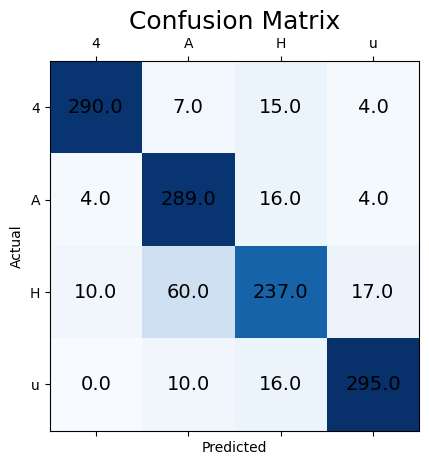

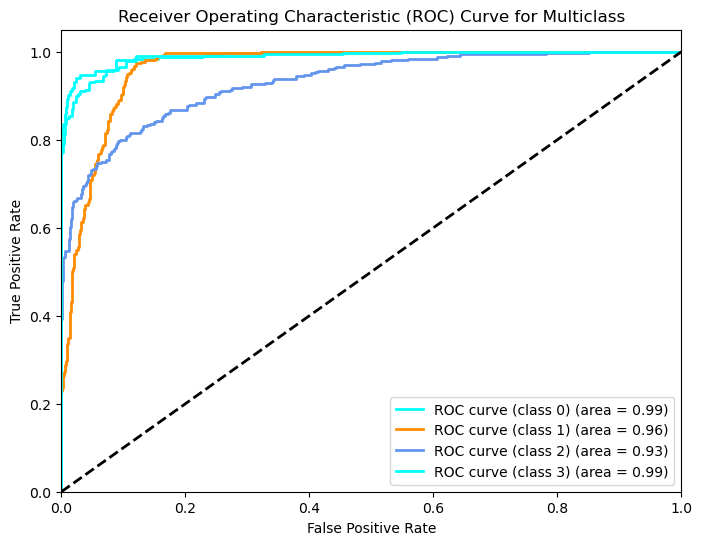

In [85]:
p=clf.predict(x_train)
ev=evaluate_classification_model(y_train, p,multiclass=True,classes_name=[encodig_dic[class_name] for class_name in np.unique(y_train) ])
ev.print_model_report()
ev.conf_matrix()
multiclass_ROC(clf,x_train,y_train)

* We can also note that the model's performance on the training data is slightly better than on the validation data.  
This could suggest a potential for overfitting, but the difference isn't significant,indicating that the model is not substantially overfitting.

## Test Multiclass Classification Model 

* Following model training and evaluation, we put the model to the test using the test data to assess its performance.

+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  metric   |    4     |    A     |    H     |    u     |  Macro average  |  Micro average  |
+===========+==========+==========+==========+==========+=================+=================+
| precision | 0.913462 | 0.676692 | 0.747475 | 0.890756 |    0.807096     |    0.802198     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
|  recall   | 0.840708 | 0.810811 | 0.637931 | 0.921739 |    0.802198     |    0.802198     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| accuracy  | 0.940659 | 0.859341 | 0.852747 | 0.951648 |    0.901099     |    0.901099     |
+-----------+----------+----------+----------+----------+-----------------+-----------------+
| f1_score  | 0.875576 | 0.737705 | 0.688372 | 0.905983 |    0.804941     |    0.804639     |
+-----------+----------+----------+----------+----------+---

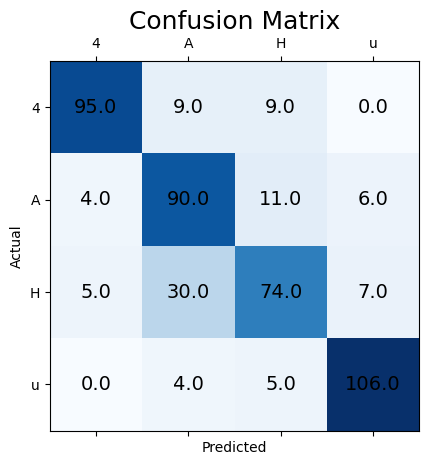

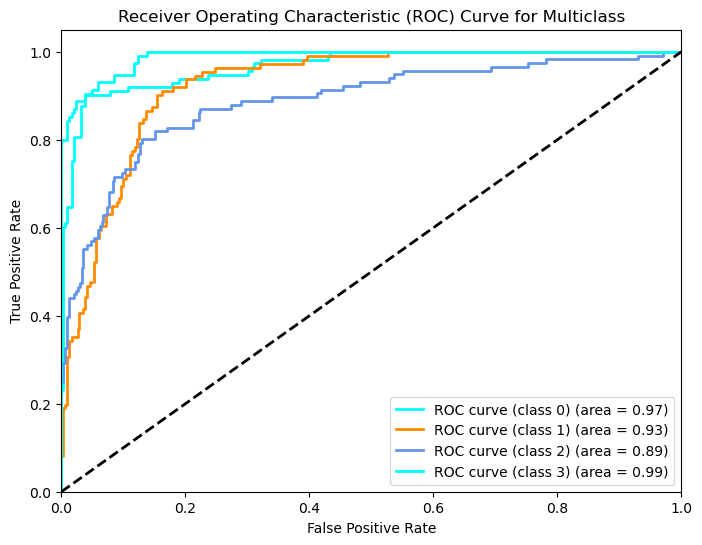

In [86]:
p=clf.predict(x_test)
ev=evaluate_classification_model(y_test, p,multiclass=True,classes_name=[encodig_dic[class_name] for class_name in np.unique(y_train) ])
ev.print_model_report()
ev.conf_matrix()
multiclass_ROC(clf,x_test,y_test)

* It's evident that the model performs well with the test data, demonstrating its capability to classify the data with reasonable accuracy.

---
---
---
---